0. Colab Setup

In [1]:
!pip -q install scikit-learn pandas matplotlib joblib

1. Imports & Reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


# For reproducibility of the train/test split
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# Make plots a bit larger
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True

2. Load the Dataset & Train Model

In [3]:
# Load California Housing (8 numerical features, ~20K rows)
cal = fetch_california_housing(as_frame=True)
X_full = cal.data
y = cal.target # Median house value in $100,000s


# Inspect
print(cal.DESCR.split('\n')[0:12]) # first lines of description
X_full.head(), y.head()

['.. _california_housing_dataset:', '', 'California Housing dataset', '--------------------------', '', '**Data Set Characteristics:**', '', ':Number of Instances: 20640', '', ':Number of Attributes: 8 numeric, predictive attributes and the target', '', ':Attribute Information:']


(   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
 0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
 1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
 2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
 3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
 4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
 
    Longitude  
 0    -122.23  
 1    -122.22  
 2    -122.24  
 3    -122.25  
 4    -122.25  ,
 0    4.526
 1    3.585
 2    3.521
 3    3.413
 4    3.422
 Name: MedHouseVal, dtype: float64)

3. Create One-Feature and Two-Feature Datasets

In [4]:
# One feature: AveRooms
X1 = X_full[["AveRooms"]].copy()


# Two features: AveRooms + MedInc
X2 = X_full[["AveRooms", "MedInc"]].copy()

4. Train/Test Split

In [5]:
X1_train, X1_test, y_train, y_test = train_test_split(
X1, y, test_size=0.2, random_state=RANDOM_STATE
)


X2_train, X2_test, _, _ = train_test_split(
X2, y, test_size=0.2, random_state=RANDOM_STATE
) # same split index as above due to same random_state

5. Train Linear Regression Models

In [6]:
lin1 = LinearRegression()
lin1.fit(X1_train, y_train)


lin2 = LinearRegression()
lin2.fit(X2_train, y_train)


print("One-feature coefficients:", lin1.coef_, "Intercept:", lin1.intercept_)
print("Two-feature coefficients:", lin2.coef_, "Intercept:", lin2.intercept_)

One-feature coefficients: [0.07675559] Intercept: 1.6547622685968417
Two-feature coefficients: [-0.04017161  0.43626089] Intercept: 0.5972677793933261


6. Evaluate on Test Set

In [8]:
# Predictions
p1 = lin1.predict(X1_test)
p2 = lin2.predict(X2_test)


# Metrics helper


def regression_report(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  return {
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2
  }


report1 = regression_report(y_test, p1)
report2 = regression_report(y_test, p2)


print("One-feature (AveRooms) Test Metrics:\n", report1)
print("\nTwo-feature (AveRooms + MedInc) Test Metrics:\n", report2)

One-feature (AveRooms) Test Metrics:
 {'MAE': 0.8891490366373881, 'MSE': 1.2923314440807299, 'RMSE': np.float64(1.1368075668646518), 'R2': 0.013795337532284901}

Two-feature (AveRooms + MedInc) Test Metrics:
 {'MAE': 0.6246828077139719, 'MSE': 0.7021550469058007, 'RMSE': np.float64(0.8379469236806115), 'R2': 0.4641710652437856}


7. Visualizations with matplotlib

  7.1 Scatter + Regression Line (One Feature)

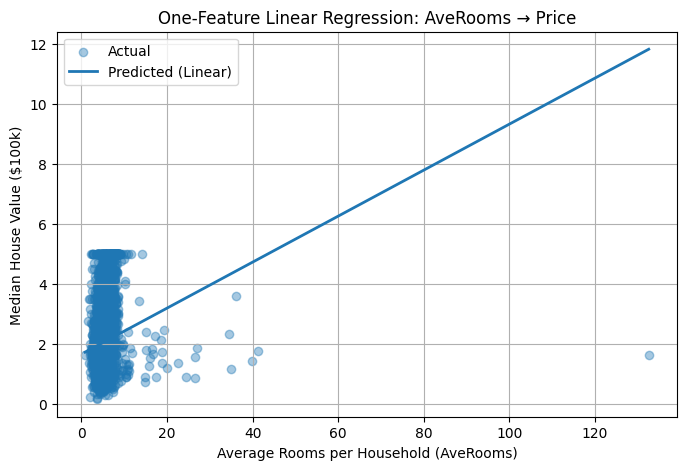

In [9]:
# Sort by feature for a clean line plot
order = np.argsort(X1_test["AveRooms"].values)
X1_sorted = X1_test.iloc[order]
y_sorted = y_test.iloc[order]
p1_sorted = p1[order]


plt.figure()
plt.scatter(X1_sorted["AveRooms"], y_sorted, alpha=0.4, label="Actual")
plt.plot(X1_sorted["AveRooms"], p1_sorted, linewidth=2, label="Predicted (Linear)")
plt.xlabel("Average Rooms per Household (AveRooms)")
plt.ylabel("Median House Value ($100k)")
plt.title("One-Feature Linear Regression: AveRooms → Price")
plt.legend()
plt.show()

7.2 Actual vs Predicted (Two Features)

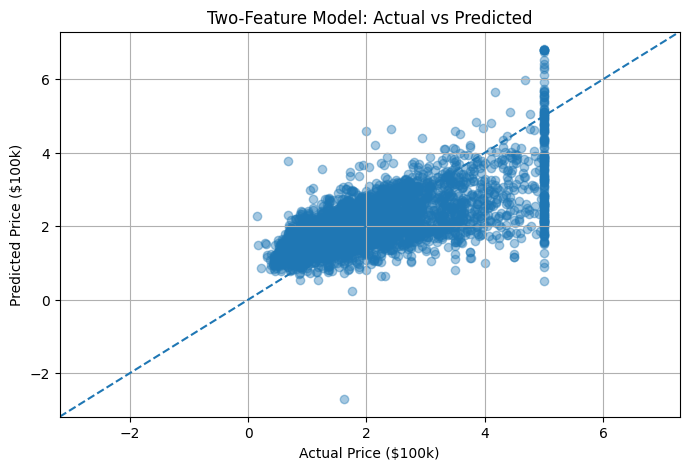

In [10]:
plt.figure()
plt.scatter(y_test, p2, alpha=0.4)
plt.xlabel("Actual Price ($100k)")
plt.ylabel("Predicted Price ($100k)")
plt.title("Two-Feature Model: Actual vs Predicted")
# 45° reference line
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, linestyle='--')
plt.xlim(lims)
plt.ylim(lims)
plt.show()

7.3 Residuals Plot (Two Features)

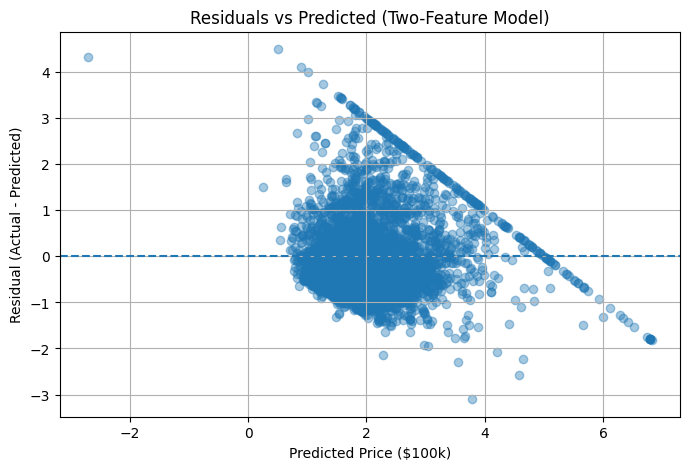

In [11]:
residuals = y_test - p2
plt.figure()
plt.scatter(p2, residuals, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Price ($100k)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Two-Feature Model)")
plt.show()

7.4 3D Scatter + Plane (Two Features)

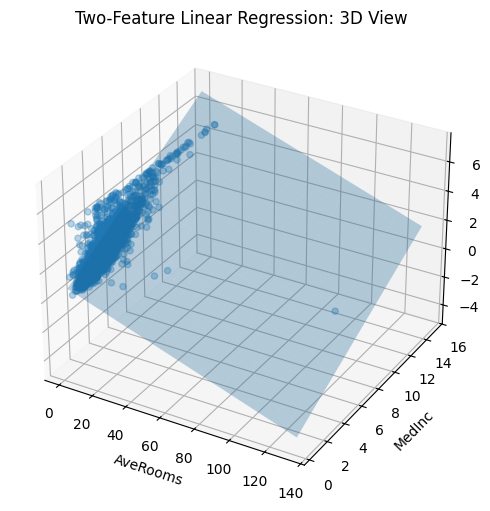

In [12]:
from mpl_toolkits.mplot3d import Axes3D # noqa: F401 (needed for 3D projection)


fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')


# Sample a subset for lighter plotting
idx = np.random.choice(len(X2_test), size=2000, replace=False)
X2_sub = X2_test.iloc[idx]
y_sub = y_test.iloc[idx]


ax.scatter(X2_sub["AveRooms"], X2_sub["MedInc"], y_sub, alpha=0.3)
ax.set_xlabel("AveRooms")
ax.set_ylabel("MedInc")
ax.set_zlabel("Price ($100k)")
ax.set_title("Two-Feature Linear Regression: 3D View")


# Fit plane values on a grid
xr = np.linspace(X2_test["AveRooms"].min(), X2_test["AveRooms"].max(), 20)
yr = np.linspace(X2_test["MedInc"].min(), X2_test["MedInc"].max(), 20)
XX, YY = np.meshgrid(xr, yr)
ZZ = lin2.intercept_ + lin2.coef_[0]*XX + lin2.coef_[1]*YY


ax.plot_surface(XX, YY, ZZ, alpha=0.3)
plt.show()

8. Cross-Validation

In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(LinearRegression(), X2, y, cv=kfold, scoring='r2')
print("5-Fold CV R^2 (two-feature):", cv_scores)
print("Mean R^2:", cv_scores.mean())

5-Fold CV R^2 (two-feature): [0.46417107 0.48898796 0.47921168 0.50132969 0.45347119]
Mean R^2: 0.4774343152132097


9. Save & Load the Model

In [14]:
# Save
joblib.dump(lin2, "linear_regression_two_features.joblib")


# Load later
loaded_model = joblib.load("linear_regression_two_features.joblib")
print("Loaded model R^2 on test:", loaded_model.score(X2_test, y_test))

Loaded model R^2 on test: 0.4641710652437856


10. Predict for New Houses

In [16]:
# Example: predict price given AveRooms & MedInc
new_data = pd.DataFrame({
"AveRooms": [5.0, 6.5, 7.2],
"MedInc": [3.0, 5.0, 8.0]
})


pred_prices = lin2.predict(new_data)
for i, p in enumerate(pred_prices, start=1):
  print(f"House {i} predicted price: ${p*100_000:,.0f}")

House 1 predicted price: $170,519
House 2 predicted price: $251,746
House 3 predicted price: $379,812


11. Gradio Interface

In [22]:
# ✅ Make sure Gradio is imported
import gradio as gr
import pandas as pd
import joblib

# Load trained model
model = joblib.load("linear_regression_two_features.joblib")

# Define prediction function
def predict_price(ave_rooms, med_inc):
    X_new = pd.DataFrame({
        "AveRooms": [ave_rooms],
        "MedInc": [med_inc]
    })
    pred = model.predict(X_new)[0]
    return f"Predicted House Price: ${pred*100_000:,.0f}"

# Gradio Interface
iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Average Rooms per Household"),
        gr.Number(label="Median Income (10k$)")
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="🏠 House Price Prediction (Linear Regression)",
    description="Enter average rooms per household and median income to predict median house price (California Housing dataset)."
)

# Launch app
iface.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e59358ddde10246c5e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e59358ddde10246c5e.gradio.live
